In [3]:
# ============================================================
# 06_hybrid_ensemble.ipynb
# Hybrid Meta-Ensemble Model (BiLSTM/Logits + XGBoost + LightGBM)
# ============================================================
# - Reuses your trained LSTM (logits output; BCEWithLogitsLoss)
# - Applies sigmoid only at inference
# - Uses the LSTM's own scaler if available (for consistency)
# - Stacks LSTM probs + XGB + LGB into a logistic meta-learner
# ============================================================

# ----------------------------
# 1) Imports & environment
# ----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
import joblib
import torch
from torch import nn

plt.style.use("seaborn-v0_8-whitegrid")
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# ----------------------------
# 2) Load preprocessed dataset
# ----------------------------
df = pd.read_csv("../data/processed/stocks_news_merged.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Ticker", "Date"]).reset_index(drop=True)

# Ensure sentiment column is present
if "avg_sentiment_score" not in df.columns:
    candidates = [c for c in df.columns if ("sent" in c.lower()) or ("finbert" in c.lower())]
    if not candidates:
        raise KeyError("No sentiment column found (expected something like 'avg_sentiment_score').")
    df = df.rename(columns={candidates[0]: "avg_sentiment_score"})

# Target + returns
if "Return" not in df.columns:
    df["Return"] = df.groupby("Ticker")["Close"].pct_change()
df["UpDown"] = (df["Return"] > 0).astype(int)

In [5]:
# ----------------------------
# 3) Base engineered features
# ----------------------------
df["Return"] = df.groupby("Ticker")["Close"].pct_change()
df["Return_lag1"] = df.groupby("Ticker")["Return"].shift(1)
df["Return_lag2"] = df.groupby("Ticker")["Return"].shift(2)
df["Return_lag3"] = df.groupby("Ticker")["Return"].shift(3)
df["return_ma5"]  = df.groupby("Ticker")["Return"].rolling(5).mean().reset_index(0, drop=True)
df["Volatility"]  = df.groupby("Ticker")["Return"].rolling(5).std().reset_index(0, drop=True)
df["price_mom5"]  = df.groupby("Ticker")["Close"].pct_change(5)
df["price_trend5"]= df.groupby("Ticker")["Close"].rolling(5).mean().reset_index(0, drop=True)

df["sentiment_lag1"] = df.groupby("Ticker")["avg_sentiment_score"].shift(1)
df["sentiment_lag2"] = df.groupby("Ticker")["avg_sentiment_score"].shift(2)
df["sentiment_lag3"] = df.groupby("Ticker")["avg_sentiment_score"].shift(3)
df["sentiment_ma3"]  = df.groupby("Ticker")["avg_sentiment_score"].rolling(3).mean().reset_index(0, drop=True)
df["sentiment_ma5"]  = df.groupby("Ticker")["avg_sentiment_score"].rolling(5).mean().reset_index(0, drop=True)
df["sentiment_std5"] = df.groupby("Ticker")["avg_sentiment_score"].rolling(5).std().reset_index(0, drop=True)
df["sentiment_mom"]  = df.groupby("Ticker")["avg_sentiment_score"].diff(1)

df["return_sent_corr"]       = df["Return"].rolling(5).corr(df["avg_sentiment_score"])
df["sentiment_vol_interact"] = df["avg_sentiment_score"] * df["Volatility"]

features = [
    "sentiment_lag1","sentiment_lag2","sentiment_lag3",
    "sentiment_ma3","sentiment_ma5","sentiment_std5","sentiment_mom",
    "Return_lag1","Return_lag2","Return_lag3","return_ma5","Volatility",
    "price_mom5","price_trend5","sentiment_vol_interact","return_sent_corr"
]
target = "UpDown"

# ============================================================
# 🔧 Extended Feature Engineering (index-aligned)
# ============================================================
df["sentiment_mom2"] = df.groupby("Ticker")["avg_sentiment_score"].diff(2)
df["sentiment_return_interact"] = df["avg_sentiment_score"] * df["Return"]
df["Volatility_10"] = df.groupby("Ticker")["Return"].transform(lambda x: x.rolling(10).std())

def calc_rsi(series, window=10):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    roll_up = gain.rolling(window).mean()
    roll_down = loss.rolling(window).mean()
    rs = roll_up / (roll_down + 1e-9)
    return 100 - (100 / (1 + rs))

df["RSI_10"] = df.groupby("Ticker")["Close"].transform(calc_rsi)

features += ["sentiment_mom2", "sentiment_return_interact", "Volatility_10", "RSI_10"]

# Drop NaNs after all features are added
df = df.dropna(subset=features + [target]).reset_index(drop=True)
print(f"✅ Added extended features. Total feature count: {len(features)}")

✅ Added extended features. Total feature count: 20


In [6]:
# ----------------------------
# 4) Scaling setup (robust to feature-count changes)
# ----------------------------
X_full = df[features].values
y_full = df[target].values
current_feat_count = X_full.shape[1]

tab_scaler = StandardScaler()
X_scaled_tab = tab_scaler.fit_transform(X_full)

# Try loading LSTM scaler safely
try:
    loaded_lstm_scaler = joblib.load("../models/best_bilstm_scaler.joblib")
    n_in = getattr(loaded_lstm_scaler, "n_features_in_", None)
    if n_in == current_feat_count:
        lstm_scaler = loaded_lstm_scaler
        print(f"✅ Loaded LSTM scaler with matching features: {n_in}")
    else:
        print(f"⚠️ LSTM scaler feature mismatch (saved={n_in}, now={current_feat_count}). Using fresh scaler.")
        lstm_scaler = tab_scaler
except Exception as e:
    print(f"⚠️ Could not load LSTM scaler ({e}). Using fresh scaler.")
    lstm_scaler = tab_scaler


✅ Loaded LSTM scaler with matching features: 20


In [7]:
# ----------------------------
# 5) Helper: make_sequences
# ----------------------------
SEQ_LEN = 25
def make_sequences(X, seq_len):
    Xs = []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
    return np.array(Xs)


In [ ]:
# ----------------------------
# 6) Load pretrained LSTM
# ----------------------------
import torch
from torch import nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=128, num_layers=3, dropout=0.3, bidirectional=True):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=bidirectional
        )
        fc_input = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Sequential(
            nn.Linear(fc_input, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x # return raw logits, sigmoid applied later

# ----------------------------
# Initialize model
# ----------------------------
lstm_model = LSTMModel(input_dim=len(features), hidden_dim=128, num_layers=3, dropout=0.3).to(device)

# ----------------------------
# Attempt to load pretrained weights
# ----------------------------
loaded = False
for path in [
    "best_bilstm.pt",                       # try local best
    "../models/improved_lstm_state_dict.pt" # try previous project folder
]:
    try:
        state_dict = torch.load(path, map_location=device)
        # Only keep keys that match shape and name
        model_dict = lstm_model.state_dict()
        filtered = {k: v for k, v in state_dict.items() if k in model_dict and v.shape == model_dict[k].shape}
        model_dict.update(filtered)
        lstm_model.load_state_dict(model_dict, strict=False)
        print(f"✅ Loaded compatible weights from {path} ({len(filtered)} layers matched).")
        loaded = True
        break
    except Exception as e:
        print(f"⚠ Could not load pretrained LSTM weights from {path}: {e}")

if not loaded:
    print("⚠️ No compatible pretrained weights found — using fresh initialization.")

lstm_model.eval()

# ----------------------------
# (Optional) Save for reuse
# ----------------------------
torch.save(lstm_model.state_dict(), "lstm_model.pth")
print("💾 LSTM state_dict saved to lstm_model.pth")


✅ Loaded compatible weights from best_bilstm.pt (24 layers matched).
💾 LSTM state_dict saved to lstm_model.pth


In [9]:
# ----------------------------
# 7) Define base learners & meta-model
# ----------------------------
xgb_model = xgb.XGBClassifier(
    n_estimators=300, learning_rate=0.05, max_depth=4,
    subsample=0.8, colsample_bytree=0.8, random_state=42,
    eval_metric="logloss"
)
lgb_model = lgb.LGBMClassifier(
    n_estimators=300, learning_rate=0.05, max_depth=4,
    subsample=0.8, colsample_bytree=0.8, random_state=42
)
meta_model = LogisticRegression(max_iter=1000)

In [10]:
# ----------------------------
# 8) Per-Ticker Meta-Feature Construction
# ----------------------------
meta_records = []

for ticker, group in df.groupby("Ticker"):
    group = group.sort_values("Date")
    split_idx = int(0.8 * len(group))

    if len(group) <= SEQ_LEN + 30:
        continue

    X_ticker = group[features]
    y_ticker = group[target]

    X_train, y_train = X_ticker.iloc[:split_idx], y_ticker.iloc[:split_idx]
    X_test,  y_test  = X_ticker.iloc[split_idx:], y_ticker.iloc[split_idx:]

    # --- Fit tabular models ---
    xgb_model.fit(tab_scaler.transform(X_train), y_train)
    lgb_model.fit(tab_scaler.transform(X_train), y_train)

    # --- Predict tabular ---
    xgb_probs = xgb_model.predict_proba(tab_scaler.transform(X_test))[:, 1]
    lgb_probs = lgb_model.predict_proba(tab_scaler.transform(X_test))[:, 1]

    # --- LSTM sequences ---
    X_scaled_lstm = lstm_scaler.transform(X_ticker)
    X_seq = make_sequences(X_scaled_lstm[split_idx:], SEQ_LEN)
    y_seq = y_ticker.values[split_idx + SEQ_LEN:]
    if len(y_seq) == 0:
        continue

    with torch.no_grad():
        xb = torch.tensor(X_seq, dtype=torch.float32).to(device)
        logits = lstm_model(xb).squeeze()
        lstm_probs = torch.sigmoid(logits).cpu().numpy()

    # Align arrays
    min_len = min(len(y_seq), len(lstm_probs), len(xgb_probs[SEQ_LEN:]), len(lgb_probs[SEQ_LEN:]))
    if min_len == 0:
        continue

    y_seq = y_seq[:min_len]
    lstm_probs = lstm_probs[:min_len]
    xgb_probs = xgb_probs[SEQ_LEN:SEQ_LEN + min_len]
    lgb_probs = lgb_probs[SEQ_LEN:SEQ_LEN + min_len]

    # --- Meta-level combination ---
    meta_X = np.column_stack([lstm_probs, xgb_probs, lgb_probs])
    meta_model.fit(meta_X, y_seq)
    meta_probs = meta_model.predict_proba(meta_X)[:, 1]
    meta_preds = (meta_probs > 0.5).astype(int)

    for i in range(min_len):
        meta_records.append({
            "Ticker": ticker,
            "true": y_seq[i],
            "lstm_prob": lstm_probs[i],
            "xgb_prob": xgb_probs[i],
            "lgb_prob": lgb_probs[i],
            "ensemble_prob": meta_probs[i],
            "ensemble_pred": meta_preds[i],
        })

meta_df = pd.DataFrame(meta_records)
print(f"✅ Meta data built for {meta_df['Ticker'].nunique()} tickers, {len(meta_df)} samples.")
display(meta_df.head())

c:\Users\User\Desktop\Data Science\Fall 2025\Generative AI\Project\genai-financial-doc-analysis\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\User\Desktop\Data Science\Fall 2025\Generative AI\Project\genai-financial-doc-analysis\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 158, number of negative: 148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2060
[LightGBM] [Info] Number of data points in the train set: 306, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.516340 -> initscore=0.065383
[LightGBM] [Info] Start training from score 0.065383
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

c:\Users\User\Desktop\Data Science\Fall 2025\Generative AI\Project\genai-financial-doc-analysis\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\User\Desktop\Data Science\Fall 2025\Generative AI\Project\genai-financial-doc-analysis\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\User\Desktop\Data Science\Fall 2025\Generative AI\Project\genai-financial-doc-analysis\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\User\Desktop\Data Science\Fall 2025\Generative AI\Project\genai-financial-doc-analysis\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 79, number of negative: 66
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1000
[LightGBM] [Info] Number of data points in the train set: 145, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.544828 -> initscore=0.179793
[LightGBM] [Info] Start training from score 0.179793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

c:\Users\User\Desktop\Data Science\Fall 2025\Generative AI\Project\genai-financial-doc-analysis\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\User\Desktop\Data Science\Fall 2025\Generative AI\Project\genai-financial-doc-analysis\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\User\Desktop\Data Science\Fall 2025\Generative AI\Project\genai-financial-doc-analysis\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\User\Desktop\Data Science\Fall 2025\Generative AI\Project\genai-financial-doc-analysis\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


,Ticker,true,lstm_prob,xgb_prob,lgb_prob,ensemble_prob,ensemble_pred
0,AAPL,1,0.510156,0.987485,0.999972,0.924032,1
1,AAPL,1,0.510124,0.993282,0.999996,0.924964,1
2,AAPL,1,0.509792,0.992053,0.999993,0.924768,1
3,AAPL,1,0.509290,0.991077,0.999991,0.924612,1
4,AAPL,0,0.509142,0.011379,0.000020,0.111650,0


Schema and sanity check

In [12]:
# --- Meta Data Audit: Schema & Integrity ---
assert 'meta_df' in globals(), "meta_df not found. Run the meta-feature construction cell first."

# 1) Basic peek
print("Rows:", len(meta_df))
print("Columns:", list(meta_df.columns))
display(meta_df.head(10))

# 2) Standardize expected columns
# Try to infer the target and prob columns in a flexible way
prob_cols = [c for c in meta_df.columns if c.endswith('_prob') or c in ['lstm_prob','xgb_prob','lgb_prob','rf_prob','cat_prob']]
candidate_targets = [c for c in ['y', 'y_true', 'true', 'UpDown', 'label'] if c in meta_df.columns]
target_col = candidate_targets[0] if candidate_targets else None
id_cols = [c for c in ['Date','date','Ticker','ticker','Symbol','symbol'] if c in meta_df.columns]

print("\nDetected:")
print("  prob_cols:", prob_cols)
print("  target_col:", target_col)
print("  id_cols:", id_cols)

# 3) Dtypes & nulls
print("\nDtypes:")
print(meta_df.dtypes)
print("\nNull counts:")
print(meta_df.isnull().sum().sort_values(ascending=False).head(20))

# 4) Drop rows with any missing prob/target (report before/after)
pre_n = len(meta_df)
need_cols = prob_cols + ([target_col] if target_col else [])
clean_meta = meta_df.dropna(subset=need_cols) if need_cols else meta_df.copy()
print(f"\nDropped {pre_n - len(clean_meta)} rows due to NaNs in {need_cols}.")

# 5) Unique IDs overview
if 'Ticker' in clean_meta.columns and any(c.lower()=='date' for c in clean_meta.columns):
    dcol = next(c for c in clean_meta.columns if c.lower()=='date')
    print("\nTickers:", clean_meta['Ticker'].nunique(), sorted(clean_meta['Ticker'].unique().tolist()))
    print("Date range:", clean_meta[dcol].min(), "→", clean_meta[dcol].max())

# Keep a working copy for later steps
meta_work = clean_meta.copy()


Rows: 64
Columns: ['Ticker', 'true', 'lstm_prob', 'xgb_prob', 'lgb_prob', 'ensemble_prob', 'ensemble_pred']


,Ticker,true,lstm_prob,xgb_prob,lgb_prob,ensemble_prob,ensemble_pred
0,AAPL,1,0.510156,0.987485,0.999972,0.924032,1
1,AAPL,1,0.510124,0.993282,0.999996,0.924964,1
2,AAPL,1,0.509792,0.992053,0.999993,0.924768,1
3,AAPL,1,0.509290,0.991077,0.999991,0.924612,1
4,AAPL,0,0.509142,0.011379,0.000020,0.111650,0
5,AAPL,1,0.509174,0.994132,0.999997,0.925099,1
6,AAPL,1,0.509243,0.993370,0.999995,0.924978,1
7,AAPL,0,0.509486,0.013215,0.000015,0.112067,0
8,AAPL,0,0.509739,0.008972,0.000008,0.111101,0
9,AAPL,0,0.510025,0.008842,0.000011,0.111072,0



Detected:
  prob_cols: ['lstm_prob', 'xgb_prob', 'lgb_prob', 'ensemble_prob']
  target_col: true
  id_cols: ['Ticker']

Dtypes:
Ticker            object
true               int32
lstm_prob        float32
xgb_prob         float32
lgb_prob         float64
ensemble_prob    float64
ensemble_pred      int32
dtype: object

Null counts:
Ticker           0
true             0
lstm_prob        0
xgb_prob         0
lgb_prob         0
ensemble_prob    0
ensemble_pred    0
dtype: int64

Dropped 0 rows due to NaNs in ['lstm_prob', 'xgb_prob', 'lgb_prob', 'ensemble_prob', 'true'].


### Class Imbalance (overall and pre-ticker)

In [22]:
from collections import Counter
import pandas as pd

if 'Ticker' in meta_work.columns:
    print("\nPer-ticker class balance:")
    per_list = []
    for t, group in meta_work.groupby('Ticker'):
        cnt = Counter(group[target_col])
        total = sum(cnt.values())
        row = {'Ticker': t}
        for k, v in cnt.items():
            row[f"Class {k}"] = f"{v} ({v/total:.1%})"
        per_list.append(row)
    per_df = pd.DataFrame(per_list).set_index('Ticker')
    display(per_df)



Per-ticker class balance:


,Class 1,Class 0
Ticker,,
AAPL,31 (59.6%),21 (40.4%)
AMZN,7 (58.3%),5 (41.7%)


In [23]:
summary = (
    meta_work.groupby("Ticker")
    .agg(
        n_samples=("true", "size"),
        pct_class1=("true", "mean"),
        lstm_mean=("lstm_prob", "mean"),
        lstm_std=("lstm_prob", "std"),
        xgb_mean=("xgb_prob", "mean"),
        xgb_std=("xgb_prob", "std"),
        lgb_mean=("lgb_prob", "mean"),
        lgb_std=("lgb_prob", "std"),
    )
)

# Format percentages nicely
summary["pct_class1"] = (summary["pct_class1"] * 100).round(1).astype(str) + "%"

# Add difficulty proxy (lower = more confident predictions)
summary["uncertainty_score"] = (
    1 - (abs(summary[["lstm_mean","xgb_mean","lgb_mean"]] - 0.5)).mean(axis=1) * 2
).round(3)

display(summary.style.background_gradient(cmap="PuBu"))


,n_samples,pct_class1,lstm_mean,lstm_std,xgb_mean,xgb_std,lgb_mean,lgb_std,uncertainty_score
Ticker,,,,,,,,,
AAPL,52,59.6%,0.509844,0.000434,0.594901,0.486930,0.596153,0.495445,0.866000
AMZN,12,58.3%,0.510129,0.000284,0.584304,0.495792,0.583333,0.514909,0.881000


<Axes: >

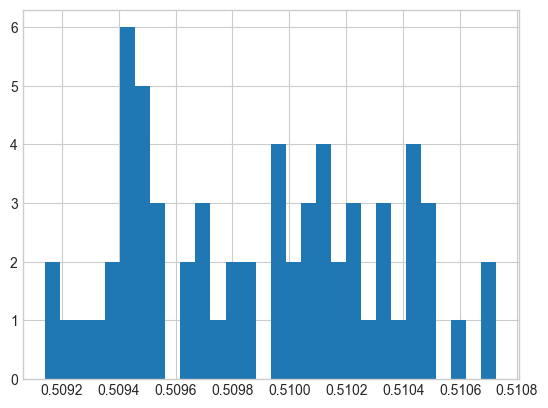

In [24]:
meta_work['lstm_prob'].hist(bins=30)


### base model probability dagnostics

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
lstm_prob,64.0,0.509898,0.000423,0.509142,0.509162,0.509298,0.509494,0.509943,0.510230,0.510488,0.510702,0.510726
xgb_prob,64.0,0.592914,0.484640,0.006165,0.006367,0.007085,0.010709,0.987244,0.992358,0.994130,0.994472,0.995021
lgb_prob,64.0,0.593749,0.495004,0.000005,0.000005,0.000007,0.000012,0.999983,0.999993,0.999996,0.999997,0.999997
ensemble_prob,64.0,0.593746,0.381718,0.110466,0.110512,0.110674,0.111498,0.814010,0.924816,0.925099,0.925153,0.925241



Correlation among base probabilities:


,lstm_prob,xgb_prob,lgb_prob,ensemble_prob
lstm_prob,1.000000,-0.071587,-0.070640,-0.074362
xgb_prob,-0.071587,1.000000,0.999951,0.992191
lgb_prob,-0.070640,0.999951,1.000000,0.991178
ensemble_prob,-0.074362,0.992191,0.991178,1.000000


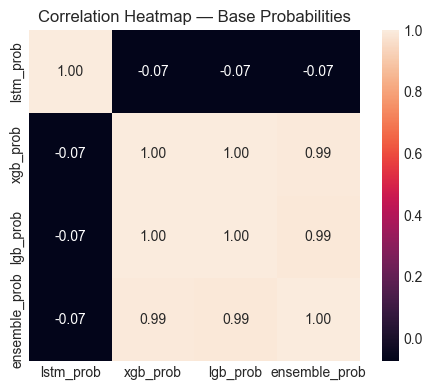

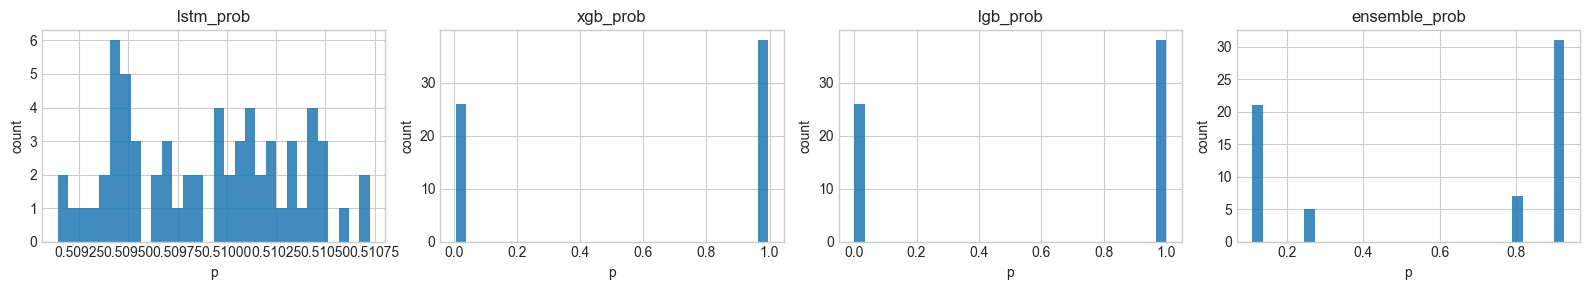

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

assert len(prob_cols) >= 2, "Need at least 2 base probability columns."

# 1) Summary stats
display(meta_work[prob_cols].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).T)

# 2) Correlation among base probabilities (diversity should NOT be too high)
corr = meta_work[prob_cols].corr()
print("\nCorrelation among base probabilities:")
display(corr)

plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, fmt=".2f", square=True, cbar=True)
plt.title("Correlation Heatmap — Base Probabilities")
plt.tight_layout()
plt.show()

# 3) Probability histograms
n = len(prob_cols)
plt.figure(figsize=(4*n, 3))
for i, c in enumerate(prob_cols, 1):
    plt.subplot(1, n, i)
    plt.hist(meta_work[c].values, bins=30, alpha=0.85)
    plt.title(c)
    plt.xlabel("p")
    plt.ylabel("count")
plt.tight_layout()
plt.show()


### Fast leakage and alignment sanity checks

In [15]:
# Heuristics to catch misalignment:
#  - probs shouldn't be "too perfect": rho(target, prob) near 1 could imply leakage
#  - duplicate (Ticker, Date) or index gaps
import numpy as np

# 1) Target-prob correlations (Spearman)
def corr_to_target(df, target):
    out = {}
    for c in prob_cols:
        try:
            out[c] = df[[c, target]].corr(method='spearman').iloc[0,1]
        except Exception:
            out[c] = np.nan
    return out

print("Spearman correlation (prob ↔ target):")
display(corr_to_target(meta_work, target_col))

# 2) Duplicate keys check
if set(['Ticker']).issubset(meta_work.columns):
    key_cols = ['Ticker']
    if any(c.lower()=='date' for c in meta_work.columns):
        key_cols.append(next(c for c in meta_work.columns if c.lower()=='date'))
    dups = meta_work.duplicated(subset=key_cols).sum()
    print(f"\nDuplicate rows by {key_cols}: {dups}")

# 3) Optional: ensure probabilities are from proper out-of-sample predictions.
# If you stored a 'fold' or 'set' column (e.g., 'train/valid/test'), check distributions:
set_col = next((c for c in ['split','fold','set'] if c in meta_work.columns), None)
if set_col:
    print(f"\nPer-{set_col} AUC (quick check):")
    from sklearn.metrics import roc_auc_score
    for s, df_s in meta_work.groupby(set_col):
        try:
            aucs = {c: roc_auc_score(df_s[target_col], df_s[c]) for c in prob_cols}
        except ValueError:
            aucs = {c: np.nan for c in prob_cols}
        print(s, aucs)


Spearman correlation (prob ↔ target):


{'lstm_prob': -0.0447773662839645,
 'xgb_prob': 0.8507796982296625,
 'lgb_prob': 0.8507699593953254,
 'ensemble_prob': 0.8507699593953254}


Duplicate rows by ['Ticker']: 62


### Meta-learner feature space preview (what exactly are we training on?)

In [16]:
# If your meta-learner uses only base probs, confirm the exact design matrix now.
# You can also enrich with simple interactions for inspection (you may or may not use them in training).
meta_features = prob_cols.copy()

# Optional diagnostics features (good to eyeball, even if you don't train with them yet)
if len(prob_cols) >= 2:
    meta_work['mean_prob'] = meta_work[prob_cols].mean(axis=1)
    meta_work['std_prob']  = meta_work[prob_cols].std(axis=1)
    meta_work['max_prob']  = meta_work[prob_cols].max(axis=1)
    meta_work['min_prob']  = meta_work[prob_cols].min(axis=1)
    meta_features += ['mean_prob','std_prob','max_prob','min_prob']

print("Meta feature columns to inspect/train:", meta_features)
display(meta_work[meta_features + [target_col] + [c for c in ['Ticker','Date'] if c in meta_work.columns]].head(10))


Meta feature columns to inspect/train: ['lstm_prob', 'xgb_prob', 'lgb_prob', 'ensemble_prob', 'mean_prob', 'std_prob', 'max_prob', 'min_prob']


,lstm_prob,xgb_prob,lgb_prob,ensemble_prob,mean_prob,std_prob,max_prob,min_prob,true,Ticker
0,0.510156,0.987485,0.999972,0.924032,0.855411,0.232559,0.999972,0.510156,1,AAPL
1,0.510124,0.993282,0.999996,0.924964,0.857091,0.233782,0.999996,0.510124,1,AAPL
2,0.509792,0.992053,0.999993,0.924768,0.856651,0.233689,0.999993,0.509792,1,AAPL
3,0.509290,0.991077,0.999991,0.924612,0.856242,0.233734,0.999991,0.509290,1,AAPL
4,0.509142,0.011379,0.000020,0.111650,0.158048,0.239377,0.509142,0.000020,0,AAPL
5,0.509174,0.994132,0.999997,0.925099,0.857101,0.234431,0.999997,0.509174,1,AAPL
6,0.509243,0.993370,0.999995,0.924978,0.856897,0.234237,0.999995,0.509243,1,AAPL
7,0.509486,0.013215,0.000015,0.112067,0.158696,0.239146,0.509486,0.000015,0,AAPL
8,0.509739,0.008972,0.000008,0.111101,0.157455,0.240201,0.509739,0.000008,0,AAPL
9,0.510025,0.008842,0.000011,0.111072,0.157488,0.240369,0.510025,0.000011,0,AAPL


In [19]:
# look at the Ticker column
print(meta_df.groupby("Ticker"))

Quick, read-only meta-learner interpretability (if using Logistic Regression)

In [17]:
# If you trained a LogisticRegression meta-learner as `meta_clf`, show coefficients & odds ratios.
if 'meta_clf' in globals():
    try:
        import numpy as np
        coefs = getattr(meta_clf, 'coef_', None)
        feats = getattr(meta_clf, 'feature_names_in_', None)
        if coefs is not None:
            coefs = coefs.ravel()
            if feats is None:
                feats = meta_features  # fallback
            coef_df = pd.DataFrame({
                'feature': feats,
                'coef': coefs,
                'odds_ratio': np.exp(coefs)
            }).sort_values('coef', key=np.abs, ascending=False)
            print("Meta-LR Coefficients (sorted by |coef|):")
            display(coef_df)
        else:
            print("meta_clf has no .coef_ (non-linear or not fitted).")
    except Exception as e:
        print("Could not display meta coefficients:", e)
else:
    print("meta_clf not found — train your meta-learner first.")


meta_clf not found — train your meta-learner first.
